In [1]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Natural Language Processing
import re
import string
import nltk
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import joblib

# Download NLTK tokenizer (needed for sentiment analysis)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
#load the dataset
df = pd.read_csv('Reviews.csv')

print("Shape: ", df.shape)
df.columns

Shape:  (568454, 10)


Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
# Keeping only the necessary columns
df = df[['Score', 'Time', 'Text']]

# Drop any rows with missing values
df = df.dropna()

# Display the first few columns
df.head()

,Score,Time,Text
0,5,1303862400,I have bought several of the Vitality canned d...
1,1,1346976000,Product arrived labeled as Jumbo Salted Peanut...
2,4,1219017600,This is a confection that has been around a fe...
3,2,1307923200,If you are looking for the secret ingredient i...
4,5,1350777600,Great taffy at a great price. There was a wid...


In [5]:
# Convert Unix timestamp to datetime
df['Time'] = pd.to_datetime(df['Time'], unit='s')

# Extract year and month for trend visualization
df['YearMonth'] = df['Time'].dt.to_period('M')

df.head()

,Score,Time,Text,YearMonth
0,5,2011-04-27,I have bought several of the Vitality canned d...,2011-04
1,1,2012-09-07,Product arrived labeled as Jumbo Salted Peanut...,2012-09
2,4,2008-08-18,This is a confection that has been around a fe...,2008-08
3,2,2011-06-13,If you are looking for the secret ingredient i...,2011-06
4,5,2012-10-21,Great taffy at a great price. There was a wid...,2012-10


In [6]:
# Check for missing values
print(df.isnull().sum())

# Remove duplicates if any
df = df.drop_duplicates()

Score        0
Time         0
Text         0
YearMonth    0
dtype: int64


In [7]:
def get_sentiment(score):
    if score <= 2:
        return 'Negative'
    elif score == 3:
        return 'Neutral'
    else: 
        return 'Positive'

df['Sentiment'] = df['Score'].apply(get_sentiment)

df.head()

,Score,Time,Text,YearMonth,Sentiment
0,5,2011-04-27,I have bought several of the Vitality canned d...,2011-04,Positive
1,1,2012-09-07,Product arrived labeled as Jumbo Salted Peanut...,2012-09,Negative
2,4,2008-08-18,This is a confection that has been around a fe...,2008-08,Positive
3,2,2011-06-13,If you are looking for the secret ingredient i...,2011-06,Negative
4,5,2012-10-21,Great taffy at a great price. There was a wid...,2012-10,Positive


In [8]:
# Check the distribution of sentiments
sentiment_distribution = df['Sentiment'].value_counts()
print(sentiment_distribution)

Sentiment
Positive    307066
Negative     57111
Neutral      29784
Name: count, dtype: int64


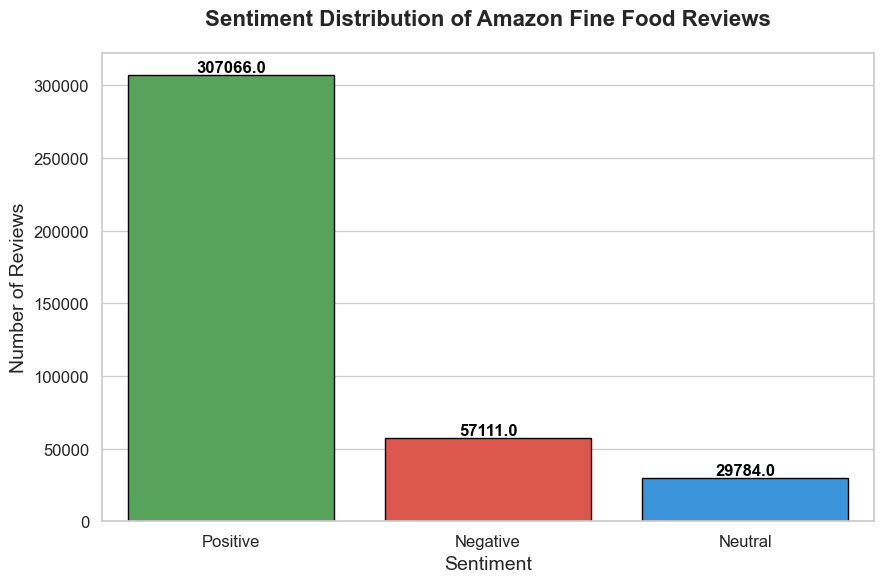

In [9]:
# Set a beautiful theme
sns.set(style='whitegrid')

custom_palette = {
    'Positive': '#4CAF50',  
    'Negative': '#F44336',  
    'Neutral':  '#2196F3'   
}

# Plot
plt.figure(figsize=(9, 6))
ax = sns.countplot(
    x='Sentiment',
    hue='Sentiment',
    data=df,
    palette=custom_palette,
    dodge=False,  # Avoid duplicate bars
    edgecolor='black'  # Clean outline
)

# Add labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

# Titles and labels
plt.title('Sentiment Distribution of Amazon Fine Food Reviews', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

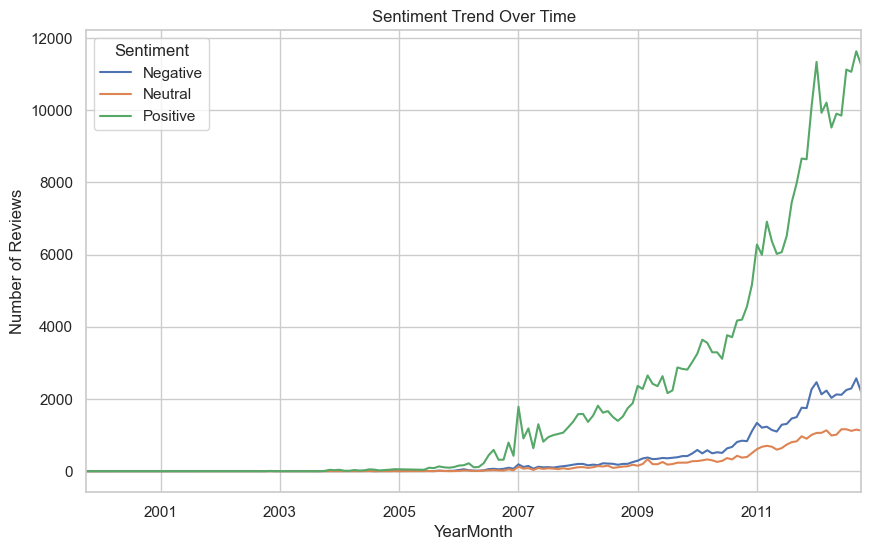

In [10]:
# Group by YearMonth and Sentiment and count the occurrences
sentiment_trend = df.groupby(['YearMonth', 'Sentiment']).size().unstack(fill_value=0)

# Plot the sentiment trend over time
sentiment_trend.plot(kind='line', figsize=(10,6))
plt.title('Sentiment Trend Over Time')
plt.ylabel('Number of Reviews')
plt.show()

In [11]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower() # Lowercase
    text = re.sub(r'\d+', '', text) # Remove Numbers
    text = text.translate(str.maketrans('', '', string.punctuation)) # Remove Punctuation
    text = text.strip() # Remove leading/Trailing whitespaces
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]) # Remove stopwords and lemmatize
    return text

df['Cleaned Text'] = df['Text'].apply(clean_text)
df.head()

,Score,Time,Text,YearMonth,Sentiment,Cleaned Text
0,5,2011-04-27,I have bought several of the Vitality canned d...,2011-04,Positive,bought several vitality canned dog food produc...
1,1,2012-09-07,Product arrived labeled as Jumbo Salted Peanut...,2012-09,Negative,product arrived labeled jumbo salted peanutsth...
2,4,2008-08-18,This is a confection that has been around a fe...,2008-08,Positive,confection around century light pillowy citrus...
3,2,2011-06-13,If you are looking for the secret ingredient i...,2011-06,Negative,looking secret ingredient robitussin believe f...
4,5,2012-10-21,Great taffy at a great price. There was a wid...,2012-10,Positive,great taffy great price wide assortment yummy ...


In [12]:
df.to_csv("cleaned_reviews.csv", index=False)

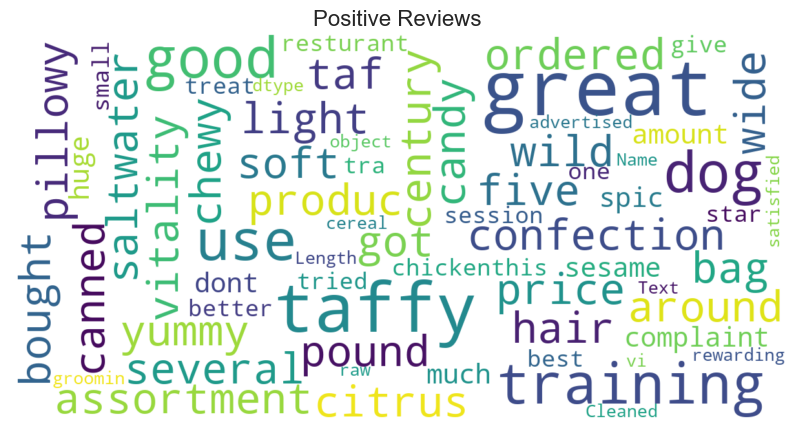

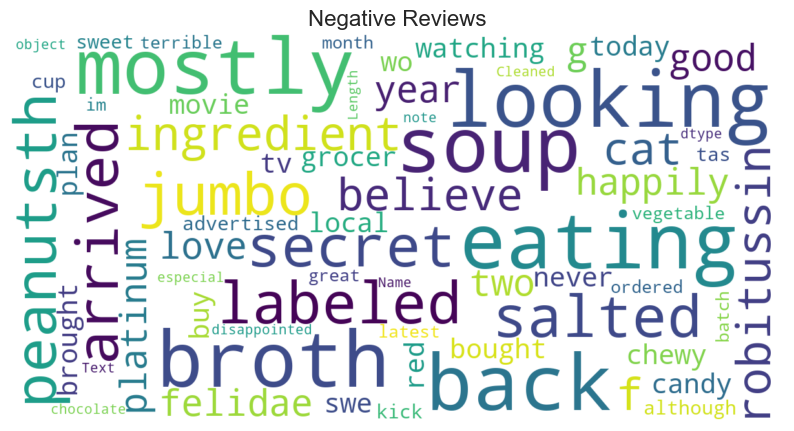

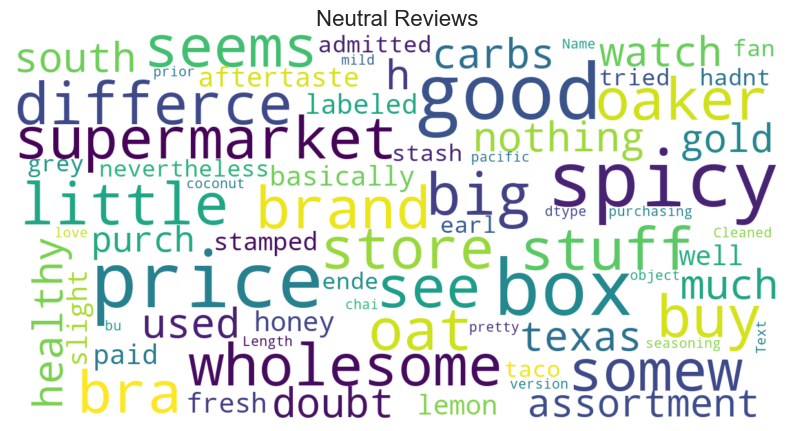

In [13]:
from wordcloud import WordCloud, STOPWORDS

custom_stopwords = STOPWORDS.union({'product', 'food', 'taste', 'flavor', 'amazon'})

def show_wordcloud(data, title=None):
    wordcloud = WordCloud(
        background_color='white',
        max_words=100,
        max_font_size=40,
        scale=3,
        random_state=1,
        collocations=False,
        stopwords=custom_stopwords
    ).generate(str(data))

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    if title:
        plt.title(title, fontsize=16)
    plt.show()

# Regenerate word clouds
show_wordcloud(df[df['Sentiment'] == 'Positive']['Cleaned Text'], "Positive Reviews")
show_wordcloud(df[df['Sentiment'] == 'Negative']['Cleaned Text'], "Negative Reviews")
show_wordcloud(df[df['Sentiment'] == 'Neutral']['Cleaned Text'], "Neutral Reviews")


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [15]:
# Initialize vectorizer with desired settings
tfidf = TfidfVectorizer(max_features=5000,
                        ngram_range=(1, 2),
                        stop_words='english')

# Fit and transform the 'Cleaned Text'
X = tfidf.fit_transform(df['Cleaned Text'])

In [16]:
y = df['Sentiment']

In [17]:
from sklearn.model_selection import train_test_split

# Split into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [18]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [19]:
from sklearn.preprocessing import LabelEncoder

# Create and fit the encoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize and train the model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Make [redictics on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Logistic Regression Accuracy: ", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Logistic Regression Accuracy:  0.8591499244856776

Classification Report:
               precision    recall  f1-score   support

    Negative       0.73      0.64      0.68     11422
     Neutral       0.47      0.14      0.22      5957
    Positive       0.89      0.97      0.93     61414

    accuracy                           0.86     78793
   macro avg       0.69      0.58      0.61     78793
weighted avg       0.83      0.86      0.84     78793



In [24]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_preds = nb_model.predict(X_test)

print("Naive Bayes Accuracy: ", accuracy_score(y_test,nb_preds))
print("\nClassification Report:\n", classification_report(y_test, nb_preds))

Naive Bayes Accuracy:  0.8213800718337924

Classification Report:
               precision    recall  f1-score   support

    Negative       0.81      0.32      0.46     11422
     Neutral       0.51      0.01      0.03      5957
    Positive       0.82      0.99      0.90     61414

    accuracy                           0.82     78793
   macro avg       0.71      0.44      0.46     78793
weighted avg       0.80      0.82      0.77     78793



In [25]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC()
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)

print("Support Vectore Machine (Linear SVM) Accuracy: ", accuracy_score(y_test,svm_pred))
print("\nClassification Report:\n", classification_report(y_test, svm_pred))

C:\Python311\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Support Vectore Machine (Linear SVM) Accuracy:  0.8587818714860457

Classification Report:
               precision    recall  f1-score   support

    Negative       0.72      0.65      0.68     11422
     Neutral       0.53      0.08      0.15      5957
    Positive       0.88      0.97      0.93     61414

    accuracy                           0.86     78793
   macro avg       0.71      0.57      0.58     78793
weighted avg       0.83      0.86      0.83     78793



In [ ]:
#from sklearn.ensemble import RandomForestClassifier

#rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
#rf_model.fit(X_train, y_train)
#rf_pred = rf_model.predict(X_test)

#print("Random Forest Accuracy: ", accuracy_score(y_test,rf_pred))
#print("\nClassification Report:\n", classification_report(y_test, rf_pred))

In [26]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train_encoded)
#xgb_pred_encoded = xgb_model.predict(X_test)
#xgb_pred = le.inverse_transform(xgb_pred_encoded)

C:\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:52:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [32]:
xgb_pred_encoded = xgb_model.predict(X_test)
xgb_pred = le.inverse_transform(xgb_pred_encoded)
from sklearn.metrics import classification_report, accuracy_score
print("XGBoost Accuracy: ", accuracy_score(y_test, xgb_pred))
print("\nClassification Report:\n", classification_report(y_test, xgb_pred))


XGBoost Accuracy:  0.8395796580914549

Classification Report:
               precision    recall  f1-score   support

    Negative       0.78      0.45      0.57     11422
     Neutral       0.50      0.09      0.16      5957
    Positive       0.85      0.98      0.91     61414

    accuracy                           0.84     78793
   macro avg       0.71      0.51      0.55     78793
weighted avg       0.81      0.84      0.81     78793



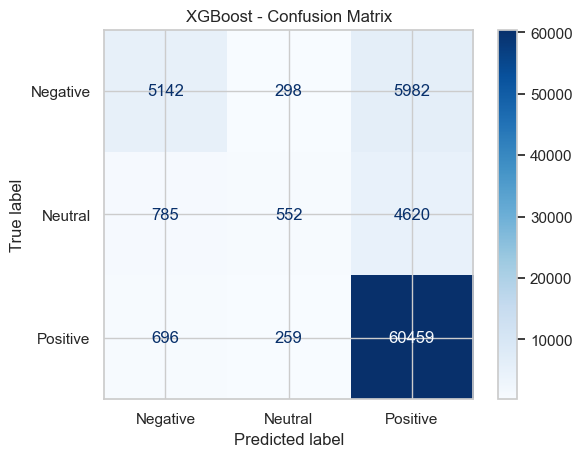


Confusion Matrix as Table:

                 Predicted Negative  Predicted Neutral  Predicted Positive
Actual Negative                5142                298                5982
Actual Neutral                  785                552                4620
Actual Positive                 696                259               60459


In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Use the predicted and actual values
cm = confusion_matrix(y_test, xgb_pred, labels=['Negative', 'Neutral', 'Positive'])

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot(cmap='Blues', values_format='d')
plt.title('XGBoost - Confusion Matrix')
plt.show()

cm_df = pd.DataFrame(cm, 
                     index=['Actual Negative', 'Actual Neutral', 'Actual Positive'], 
                     columns=['Predicted Negative', 'Predicted Neutral', 'Predicted Positive'])

print("\nConfusion Matrix as Table:\n")
print(cm_df)

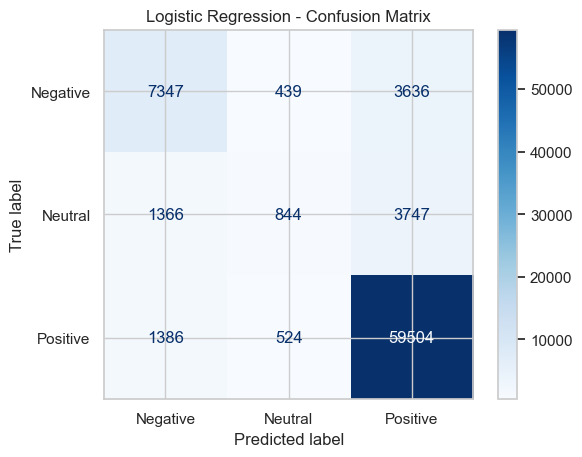


Confusion Matrix as Table:

                 Predicted Negative  Predicted Neutral  Predicted Positive
Actual Negative                7347                439                3636
Actual Neutral                 1366                844                3747
Actual Positive                1386                524               59504


In [27]:
cm_lr = confusion_matrix(y_test, y_pred, labels=['Negative', 'Neutral', 'Positive'])
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=['Negative', 'Neutral', 'Positive'])
disp_lr.plot(cmap='Blues', values_format='d')
plt.title('Logistic Regression - Confusion Matrix')
plt.show()

cm_df = pd.DataFrame(cm_lr, 
                     index=['Actual Negative', 'Actual Neutral', 'Actual Positive'], 
                     columns=['Predicted Negative', 'Predicted Neutral', 'Predicted Positive'])

print("\nConfusion Matrix as Table:\n")
print(cm_df)

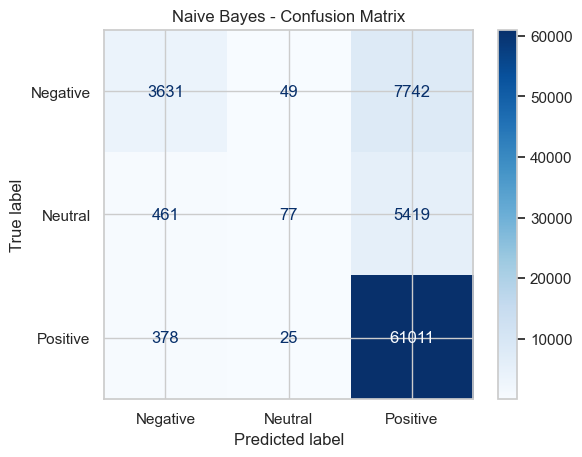


Confusion Matrix as Table:

                 Predicted Negative  Predicted Neutral  Predicted Positive
Actual Negative                3631                 49                7742
Actual Neutral                  461                 77                5419
Actual Positive                 378                 25               61011


In [28]:
cm_nb = confusion_matrix(y_test, nb_preds, labels=['Negative', 'Neutral', 'Positive'])
disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=['Negative', 'Neutral', 'Positive'])
disp_nb.plot(cmap='Blues', values_format='d')
plt.title('Naive Bayes - Confusion Matrix')
plt.show()

cm_df = pd.DataFrame(cm_nb, 
                     index=['Actual Negative', 'Actual Neutral', 'Actual Positive'], 
                     columns=['Predicted Negative', 'Predicted Neutral', 'Predicted Positive'])

print("\nConfusion Matrix as Table:\n")
print(cm_df)

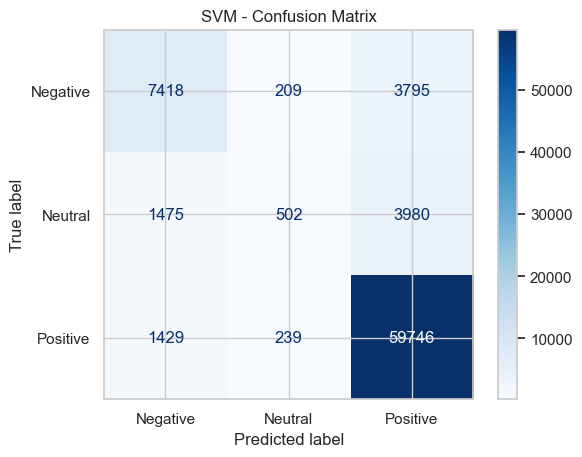


Confusion Matrix as Table:

                 Predicted Negative  Predicted Neutral  Predicted Positive
Actual Negative                7418                209                3795
Actual Neutral                 1475                502                3980
Actual Positive                1429                239               59746


In [29]:
cm_svm = confusion_matrix(y_test, svm_pred, labels=['Negative', 'Neutral', 'Positive'])
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=['Negative', 'Neutral', 'Positive'])
disp_svm.plot(cmap='Blues', values_format='d')
plt.title('SVM - Confusion Matrix')
plt.show()

cm_df = pd.DataFrame(cm_svm, 
                     index=['Actual Negative', 'Actual Neutral', 'Actual Positive'], 
                     columns=['Predicted Negative', 'Predicted Neutral', 'Predicted Positive'])

print("\nConfusion Matrix as Table:\n")
print(cm_df)

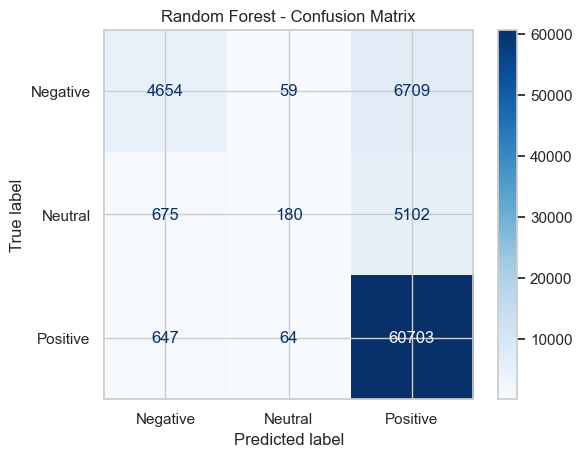


Confusion Matrix as Table:

                 Predicted Negative  Predicted Neutral  Predicted Positive
Actual Negative                4654                 59                6709
Actual Neutral                  675                180                5102
Actual Positive                 647                 64               60703


In [30]:
cm_rf = confusion_matrix(y_test, rf_pred, labels=['Negative', 'Neutral', 'Positive'])
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['Negative', 'Neutral', 'Positive'])
disp_rf.plot(cmap='Blues', values_format='d')
plt.title('Random Forest - Confusion Matrix')
plt.show()

cm_df = pd.DataFrame(cm_rf, 
                     index=['Actual Negative', 'Actual Neutral', 'Actual Positive'], 
                     columns=['Predicted Negative', 'Predicted Neutral', 'Predicted Positive'])

print("\nConfusion Matrix as Table:\n")
print(cm_df)

In [31]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc

# Binarize target for ROC
classes = ['Negative', 'Neutral', 'Positive']
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

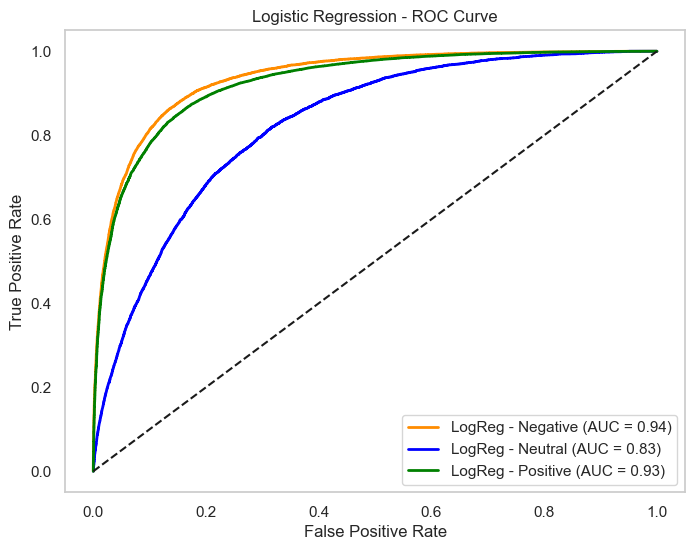

In [32]:
lr_ovr = OneVsRestClassifier(LogisticRegression(max_iter=1000))
lr_ovr.fit(X_train, label_binarize(y_train, classes=classes))
y_score_lr = lr_ovr.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score_lr[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = ['darkorange', 'blue', 'green']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'LogReg - {classes[i]} (AUC = {roc_auc[i]:.2f})')
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression - ROC Curve')
plt.legend()
plt.grid()
plt.show()

C:\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:13:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:14:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:16:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


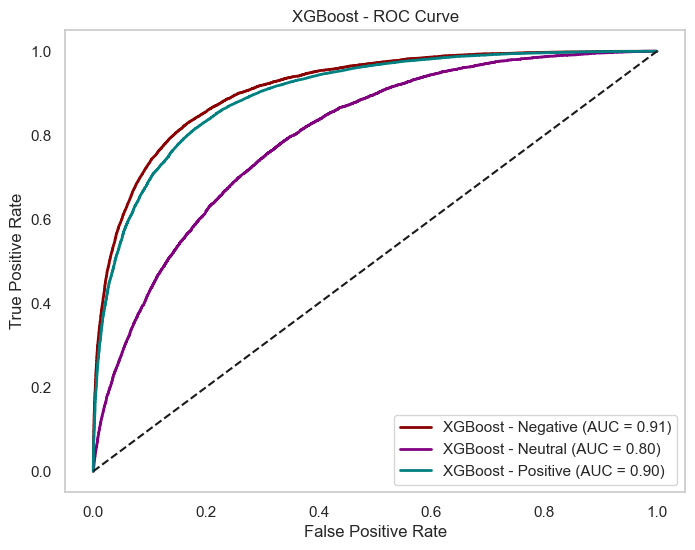

In [33]:
xgb_ovr = OneVsRestClassifier(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))
xgb_ovr.fit(X_train, label_binarize(y_train, classes=classes))
y_score_xgb = xgb_ovr.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score_xgb[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = ['darkred', 'purple', 'teal']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'XGBoost - {classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost - ROC Curve')
plt.legend()
plt.grid()
plt.show()


In [20]:

# Save all models
joblib.dump(model, 'logistic_model.pkl')
joblib.dump(xgb_model, 'xgboost_model.pkl')
joblib.dump(nb_model, 'naive_bayes_model.pkl')
joblib.dump(svm_model, 'svm_model.pkl')
#joblib.dump(rf_model, 'random_forest_model.pkl')

# Save TF-IDF vectorizer
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

NameError: name 'model' is not defined

In [ ]:
# Load all models
import joblib
log_model = joblib.load('logistic_model.pkl')
xgb_model = joblib.load('xgboost_model.pkl')
nb_model = joblib.load('naive_bayes_model.pkl')
svm_model = joblib.load('svm_model.pkl')
#rf_model = joblib.load('random_forest_model.pkl')
tfidf = joblib.load('tfidf_vectorizer.pkl')

model_dict = {
    "Logistic Regression": log_model,
    "XGBoost": xgb_model,
    "Naive Bayes": nb_model,
    "SVM": svm_model,
    #"Random Forest": rf_model
}

In [ ]:
model_accuracies = {
    'Logistic Regression': accuracy_score(y_test, log_model.predict(X_test)),
    'Naive Bayes': accuracy_score(y_test, nb_model.predict(X_test)),
    'SVM': accuracy_score(y_test, svm_model.predict(X_test)),
    #'Random Forest': accuracy_score(y_test, rf_model.predict(X_test)),
    'XGBoost': accuracy_score(y_test, xgb_pred)#'XGBoost': accuracy_score(y_test, xgb_model.predict(X_test))
}

# Save it for later use in Streamlit
import json
with open("model_accuracies.json", "w") as f:
    json.dump(model_accuracies, f)

print("✅ Model accuracies saved!")